### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import random
import os, math
import logging
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import to_categorical
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from _logging import set_logging
from _utility import get_perc, get_dictionaries_from_list
from _pckle import save_pickle_object
from _data_celeb import organise_images_in_folders

set_logging(logging)
data_folder = "celeb_small"
generator_image_folder = os.path.join(data_folder, "data")
# celeb_small\img_align_celeba\img_align_celeba
image_folder = os.path.join("celeb_small", "img_align_celeba", "img_align_celeba")
image_directory = os.path.join("celeb_small", "img_align_celeba")
class gl:
    image_id = "image_id"
    is_male = "Male"

In [2]:
df_celeb=pd.read_csv(os.path.join(data_folder,'list_attr_celeba.csv'))
df_celeb.columns.values

array(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [3]:
df_celeb.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
create_folders_flag = False
if create_folders_flag:
    organise_images_in_folders(df_celeb, gl, image_folder, data_folder)

In [5]:
df_celeb_image = df_celeb[gl.image_id].copy()

In [6]:
df_celeb_image.head()

0    000001.jpg
1    000002.jpg
2    000003.jpg
3    000004.jpg
4    000005.jpg
Name: image_id, dtype: object

#### See sample image


In [7]:
def get_image(image_folder, image_id):
    image_path = os.path.join(image_folder, image_id)
    img = load_img(image_path)
    return img

2023-01-28 14:29:04,884 | INFO : 1 000001.jpg
2023-01-28 14:29:05,286 | INFO : 2 000002.jpg
2023-01-28 14:29:05,300 | INFO : 3 000003.jpg
2023-01-28 14:29:05,318 | INFO : 4 000004.jpg
2023-01-28 14:29:05,338 | INFO : 5 000005.jpg
2023-01-28 14:29:05,373 | INFO : 6 000006.jpg
2023-01-28 14:29:05,387 | INFO : 7 000007.jpg
2023-01-28 14:29:05,399 | INFO : 8 000008.jpg
2023-01-28 14:29:05,588 | INFO : 9 000009.jpg
2023-01-28 14:29:05,608 | INFO : 10 000010.jpg


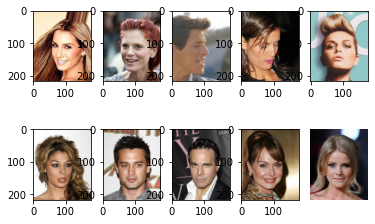

In [8]:

fig = plt.figure()   

for i, image_id in enumerate(df_celeb_image, start=1):
    if i > 10:
        break

    ax = fig.add_subplot(2,5,i)
    logging.info(f"{i} {image_id}")
    img = get_image(image_folder, image_id)
    plt.imshow(img)

plt.axis('off')
plt.show()

### 4. Build Model

- First, copy VGG16 without the dense layers, use the weights from `imagenet`. Set the input shape to `(178,218,3)`.
- Freeze the layers except the last two layers and print to see if the layers are trainable or not.
- Build your sequential model (you are free to use a functioanl API as a further exercise). Include all the frozen VGG layers to your model. Add a Dense layer with 128 inouts and `relu` activation. Add a batch nomalizer, then a dense layer as the output layer. 
- Create an early stopping criteria monitorin the loss value for the validation set. Stop the search if the loss value deosnt change for two consecutive times.
- Compile the model.
- Save the best model automatically based on the performance of the validation set.

In [9]:
_input_shape = (178, 218, 3)
_weights = "imagenet"
vgg16_model = VGG16(include_top=False, weights=_weights, input_shape=_input_shape)

# Freeze all but the last 2 layers
for layer in vgg16_model.layers[:-2]: 
    layer.trainable = False
    
for layer in vgg16_model.layers:
    print(f"Is trainable: {layer.trainable}     {layer}")

Is trainable: False     <keras.engine.input_layer.InputLayer object at 0x00000232C22097C0>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C22C93A0>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C22C9BB0>
Is trainable: False     <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000232C2493FA0>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C2340130>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C24A7B80>
Is trainable: False     <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000232C24C8DF0>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C24B47C0>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C24E30D0>
Is trainable: False     <keras.layers.convolutional.conv2d.Conv2D object at 0x00000232C24E3EE0>
Is trainable: False     <keras.

In [11]:
seq_model = Sequential()
for layer in vgg16_model.layers[:-2]:
    seq_model.add(layer)
    
seq_model.add(Flatten())
seq_model.add(Dense(units=128, activation="relu"))
seq_model.add(BatchNormalization())
seq_model.add(Dense(units=1, activation="sigmoid"))
seq_model.layers

In [12]:


# stop the search if the loss value does not change for 2 consequtive times
_patience = 2
_monitor = "val_loss"
_loss = keras.losses.BinaryCrossentropy()
#_metrics = keras.metrics.BinaryCrossentropy()
_metrics = ["accuracy"]
_optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
early = EarlyStopping(monitor=_monitor, min_delta=0, patience=_patience, verbose=1, mode="auto")
checkpoint_path = os.path.join(data_folder, "checkpoint", "vgg16_1.h5")
checkpoint = ModelCheckpoint(checkpoint_path, monitor=_monitor, verbose=1, save_best_only=True, save_weights_only=False, mode="auto", period=1)
_callbacks = [early, checkpoint]
seq_model.compile(optimizer=_optimizer, loss=_loss, metrics=_metrics)


## 5. Data Preparation

- Create a validation set with 20% of the data. Check the number of data points per class from both the train and validation sets.
- Set your batch size to 20.
- Create the data generator and set the `preprocessing_function` to `preprocess_input` of VGG16.
- Create train and validation data generators (batches will be picked up from the dataframe). Set target size to (178,218) (you can try something else, but you need to do the corresponding change in the model).
- Set your validation  and epoch step size (`validation_steps` and `steps_per_epoch`)

In [13]:
image_data_gen = ImageDataGenerator(validation_split=0.2)
_target_size = (178, 218)
_batch_size = 20

train_data_gen = image_data_gen.flow_from_directory(directory=generator_image_folder, target_size=_target_size, batch_size=_batch_size, class_mode="binary", shuffle=True, subset="training")

val_data_gen = image_data_gen.flow_from_directory(directory=generator_image_folder, target_size=_target_size, batch_size=_batch_size, class_mode="binary", shuffle=True, subset="validation")

_steps_per_epoch = math.ceil(train_data_gen.samples // _batch_size)
_steps_per_validation = math.ceil(val_data_gen.samples // _batch_size)
logging.info(f"Steps per epoch = {_steps_per_epoch}, steps per validation = {_steps_per_validation}")


Found 162080 images belonging to 2 classes.
Found 40519 images belonging to 2 classes.
2023-01-28 14:30:32,951 | INFO : Steps per epoch = 8104, steps per validation = 2025


## 6. Train the Model

- Fit the model
- save the model

In [14]:


_epochs = 20
seq_model.fit_generator(generator=train_data_gen, validation_data=val_data_gen, steps_per_epoch=_steps_per_epoch, epochs=_epochs, callbacks=_callbacks)
score = seq_model.evaluate_generator(val_data_gen)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[0]}")
save_pickle_object(seq_model, "seq_model.pkl")

C:\Users\hijik\AppData\Local\Temp\ipykernel_16752\1844144950.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  seq_model.fit_generator(generator=train_data_gen, validation_data=val_data_gen, steps_per_epoch=_steps_per_epoch, epochs=_epochs, callbacks=_callbacks)


Epoch 1/20
8104/8104 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9492
Epoch 1: val_loss improved from inf to 0.14012, saving model to celeb_small\checkpoint\vgg16_1.h5
8104/8104 [==============================] - 22879s 3s/step - loss: 0.1327 - accuracy: 0.9492 - val_loss: 0.1401 - val_accuracy: 0.9482
Epoch 2/20
8104/8104 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9682
Epoch 2: val_loss improved from 0.14012 to 0.09439, saving model to celeb_small\checkpoint\vgg16_1.h5
8104/8104 [==============================] - 21593s 3s/step - loss: 0.0885 - accuracy: 0.9682 - val_loss: 0.0944 - val_accuracy: 0.9692
Epoch 3/20
8104/8104 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9755
Epoch 3: val_loss improved from 0.09439 to 0.08216, saving model to celeb_small\checkpoint\vgg16_1.h5
8104/8104 [==============================] - 21721s 3s/step - loss: 0.0682 - accuracy: 0.9755 - val_loss: 0.0822 - val_accuracy: 0.9

C:\Users\hijik\AppData\Local\Temp\ipykernel_16752\1844144950.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = seq_model.evaluate_generator(val_data_gen)


Test loss: 0.11574515700340271
Test accuracy: 0.11574515700340271
2023-01-29 22:19:23,098 | INFO : Saving pickle file from: pickle\seq_model.pkl
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_10
......vars
.........0
.........1
...layers\conv2d_11
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\conv2d_6
......vars
.........0
.........1
...layers\conv2d_7
......vars
.........0
.........1
...layers\conv2d_8
......vars
.........0
.........1
...layers\conv2d_9
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
..

The model is very good at predicting the gender of the person in the photo. The accuracy of the model peaked on the 3rd epoch. After that the training metrics continued to improve but diverged from the validation metrics implying that the model is starting to overfit from the training data. The early stopping prevented the model from overfitting too much.
The training took a long time to run so there was no time to tune the hyperparameters. In any case the results were very good so there is not much room for improvement. 